# Assingment 3 - Contrast transfer
### Course: Convolutional Neural Networks with Applications in Medical Image Analysis

For radiotherapy treatment, often multiple contrasts are acquired of the same anatomy for better organ delineations. For the third assignment you are tasked to train a model transferring T1w MR images to a T2w contrast. If one could synthetically create additional contrasts, the patients wouldn't have to be scanned multiple times or for a long time, speeding up the scanning process.

In this assignment, you will train a Conditional GAN model, discussed in the course lectures. A GAN has two models, a generator performing the actual task and a discriminator, learning the difference between real and generated images. The generator is trained to produce images that fool the discriminator, generating images that the discriminator think are real. Apart from the adversarial loss of the discriminator, you also have a paired pixel-wise loss in the conditional GAN model (like in the previous assignment). This improves learning. There is a weight balancing the two losses, denoted $\alpha$ here.

The task is to take T1-weighted images as inputs, and generate the corresponding T2-weighted images.

The network architectures were the main focus in the previous two assignments, but here there is no need to change anything in the models. Although, you can change the models if you'd like. In fact, the only code you are tasked to change is in one cell, where the training parameters are defined (_e.g._, the learning rates, the optimizers, and the $\alpha$). The generator has been modified here to return downsampled images, to make the training easier and faster.

Your tasks, to include in the Jupyter notebook you hand in, are:
- Reach a validation MSE below 0.015 on the validation set, and describe what parameter combinations you have gone through to reach those results.
- The higher you set $\alpha$, the easier the training will be, as the adversarial loss will have a lower effect. However, your should aim to minimize $\alpha$ (note however that the lowest possible value of $\alpha$ is 0).
- If your final result is using $\alpha > 0$, that means the requried MSE might be easy to achieve. In this case, aim to minimize the MSE even below the requried threshold, until your results "look nice".
- The MSE threshold is a guideline, your main task is to describe the effect of each hyper-parameter you have changed, and the way you have experimented with them. What problems did you face? What happened when the training failed? Try describing everything that you have learnt.

Upload the updated notebook to Canvas by June $3^{rd}$, 15:00.

Good luck and have fun!

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import random
random.seed(2022)

import numpy as np
np.random.seed(2022)  # Set seed for reproducibility

import tensorflow as tf
tf.random.set_seed(2022)

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
import tensorflow.keras as keras

from scipy.ndimage import zoom
import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print(f"GPU(s) available (using '{gpus[0].name}'). Training will be lightning fast!")
else:
    print("No GPU(s) available. Training will be suuuuper slow!")

# NOTE: These are the packages you will need for the assignment.
# NOTE: You are encouraged to use the course virtual environment, which already has GPU support.

GPU(s) available (using '/physical_device:GPU:0'). Training will be lightning fast!


##### The cell below will define the data generator for the data you will be using. You should not change anything in the below code!

In [4]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self,
                 data_path,
                 arrays,
                 batch_size=32,
                 ):

        self.data_path = data_path
        self.arrays = arrays
        self.batch_size = batch_size

        if data_path is None:
            raise ValueError('The data path is not defined.')

        if not os.path.isdir(data_path):
            raise ValueError('The data path is incorrectly defined.')

        self.file_idx = 0
        self.file_list = [self.data_path + '/' + s for s in
                          os.listdir(self.data_path)]
        
        self.on_epoch_end()
        with np.load(self.file_list[0]) as npzfile:
            self.in_dims = []
            self.n_channels = 1
            for i in range(len(self.arrays)):
                im = npzfile[self.arrays[i]]
                im = zoom(im, 0.5)
                self.in_dims.append((self.batch_size,
                                    *np.shape(im),
                                    self.n_channels))

    def __len__(self):
        """Get the number of batches per epoch."""
        return int(np.floor((len(self.file_list)) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data."""
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) *
                               self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.file_list[k] for k in indexes]

        # Generate data
        a = self.__data_generation(list_IDs_temp)
        return a

    def on_epoch_end(self):
        """Update indexes after each epoch."""
        self.indexes = np.arange(len(self.file_list))
        np.random.shuffle(self.indexes)
    
    #@threadsafe_generator
    def __data_generation(self, temp_list):
        """Generate data containing batch_size samples."""
        # X : (n_samples, *dim, n_channels)
        # Initialization
        arrays = []

        for i in range(len(self.arrays)):
            arrays.append(np.empty(self.in_dims[i]).astype(np.single))

        for i, ID in enumerate(temp_list):
            with np.load(ID) as npzfile:
                for idx in range(len(self.arrays)):
                    x = npzfile[self.arrays[idx]] \
                        .astype(np.single)
                    x = zoom(x, 0.5)
                    x = np.expand_dims(x, axis=2)
                    arrays[idx][i, ] = x

        return arrays

# NOTE: Don't change the data generator!
# NOTE: There is now a resizing part of the images, this is to make training easier and faster.

In [5]:
gen_dir = "./data/" #"/import/software/3ra023/vt22/brats/data/"  # Change if you have copied the data locally on your machine 
array_labels = ["t1", "t2"] 
batch_size = 32

gen_train = DataGenerator(data_path=gen_dir + "training",
                          arrays=array_labels,
                          batch_size=batch_size)

gen_val = DataGenerator(data_path=gen_dir + "validating",
                        arrays=array_labels,
                        batch_size=batch_size)

gen_test = DataGenerator(data_path=gen_dir + "testing",
                         arrays=array_labels,
                         batch_size=batch_size)

# NOTE: The task for this assignment is fixed. The input will be T1w images, and the output T2w.

### Let's plot some example images from the dataset:

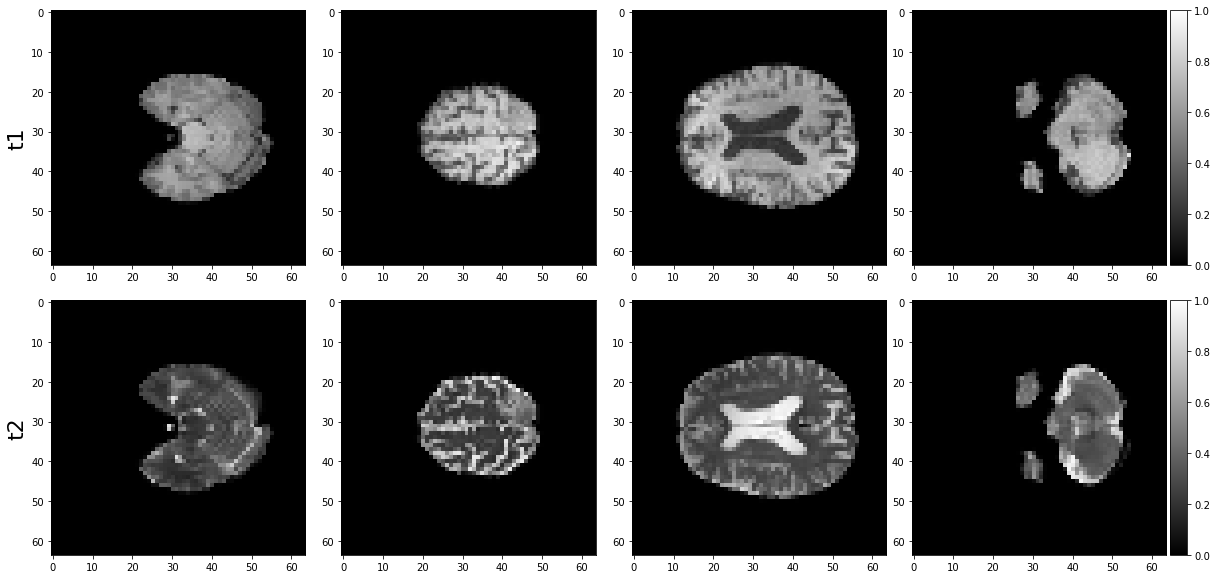

In [6]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(16.0, 8.0))
fig.subplots_adjust(left=0.001,
                    right=0.9975,
                    top=0.95,
                    bottom=0.005,
                    wspace=0.05,
                    hspace=0.14)

M, N = 2, 4
ax = []
for i in range(M):
    ax.append([None] * N)
    for j in range(N):
        ax[i][j] = plt.subplot2grid((M, N), (i, j), rowspan=1, colspan=1)

imgs = gen_train[0]
idx = np.random.randint(0, np.shape(gen_train[0][0])[0], 5)
ii = 0
for j in range(N):
    for i in range(M):
        im = ax[i][j].imshow(imgs[i][idx[ii], :, :, 0], cmap='gray', vmin=0, vmax=1)

        if j == 0:  # Label only on the left
            ax[i][j].set_ylabel(gen_train.arrays[i], fontsize=22)
        if j == N - 1:  # Colorbar only on the right
            divider = make_axes_locatable(ax[i][j])
            cax1 = divider.append_axes("right", size="7%", pad=0.05)
            cbar = plt.colorbar(im, cax=cax1)
    ii += 1    

A quick summary of the data sizes:

In [7]:
# A quick summary of the data:
print(f"Number of training images : {len(gen_train.file_list)}")
print(f"Training batch size       : {gen_train.in_dims}")

Number of training images : 8000
Training batch size       : [(32, 64, 64, 1), (32, 64, 64, 1)]


### The dataset preprocessing so far has been to help you, you should not change anything above. However, from now on, take nothing for granted.

In [8]:
# Import packages important for building and training your model.

import tensorflow.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import Flatten, Input
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout, UpSampling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from IPython.display import clear_output
%matplotlib inline

In [9]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, \
                                    Add, AveragePooling2D, Flatten, Dense, UpSampling2D, Conv2DTranspose, Concatenate, LeakyReLU
from tensorflow.keras.models import Model

def build_generator(in_shape=(64,64,1)):
    num_filt = 4
    inputs = Input(in_shape)
    conv1 = Conv2D(num_filt, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(num_filt, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(num_filt * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(num_filt * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(num_filt * 4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(num_filt * 4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(num_filt * 8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(num_filt * 8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(num_filt * 16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(num_filt * 16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(num_filt * 8, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis=3)
    conv6 = Conv2D(num_filt * 8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(num_filt * 8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(num_filt * 4, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis=3)
    conv7 = Conv2D(num_filt * 4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(num_filt * 4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(num_filt * 2, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis=3)
    conv8 = Conv2D(num_filt * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(num_filt * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(num_filt, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis=3)
    conv9 = Conv2D(num_filt, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(num_filt, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation=relu_range)(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    return model

# NOTE: The generator is a U-Net with 4 down- and upsampling layers. Maybe similar to what you have used in Assignment 2.

In [10]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, \
                                    Add, AveragePooling2D, Flatten, Dense, UpSampling2D
from tensorflow.keras.models import Model

# (Answer): Activation function is a clamped relu, where values below zero are clamped to zero and values above 1 is clamped to 1.
# This is perhaps better to constrain the network's output better between our desired outputs of 0 or 1.
def relu_range(x): # A custom made activation layer used on the output. Can you figure out what it does? And why it's better than the alternatives?
    x = tensorflow.where(K.greater(x, 0), x, K.zeros_like(x))
    x = tensorflow.where(K.less(x, 1), x, K.ones_like(x))
    return x
    
def build_discriminator(in_shape=(64,64,1)):
    num_filt = 4
    model = Sequential()
    model.add(Conv2D(num_filt, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(num_filt * 2, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(num_filt * 4, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(num_filt * 8, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(num_filt * 16, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(num_filt * 32, (3,3), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation=relu_range))
    return model

# NOTE: The discriminator is a simple convolutional model with continuous downsampling. Maybe similar to what you have used in Assignment 1.

## The below cell is all the code you are asked to modify. Change the learning rates, alpha and the optimizers to achieve the requirements.

In [11]:
#I moved this code into a build_model function, see below.

#learning_rate_dis = 0.01
#learning_rate_GAN = 0.01
#alpha = 0.5

#opt_gan = Adam(lr=learning_rate_GAN, beta_1=0.5)
#opt_dis = Adam(lr=learning_rate_dis, beta_1=0.5)

# NOTE: Describe your choices. Aim for the lowest alpha you can achieve (the lowest value is 0).

In [12]:
def build_model(learning_rate_dis, learning_rate_GAN, alpha):
    opt_gan = Adam(lr=learning_rate_GAN, beta_1=0.5)
    opt_dis = Adam(lr=learning_rate_dis, beta_1=0.5)
    
    generator = build_generator()
    discriminator = build_discriminator()
    
    generator.compile(loss="mse")
    discriminator.compile(loss='binary_crossentropy', optimizer=opt_dis, metrics=['accuracy'])

    # GAN
    discriminator.trainable = False
    for layer in discriminator.layers:
        layer.trainable = False

    inp = Input(shape=(64,64,1))
    pred = generator(inp)
    labels = discriminator(pred)
    GAN = Model(inputs=inp, outputs=[labels, pred])
    GAN.summary()

    GAN.compile(loss='binary_crossentropy', loss_weights=[1, alpha], optimizer=opt_gan)
    #print(discriminator.summary())
    return (generator, discriminator, GAN)

In [13]:
build_model(0.1, 0.1, 0);

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 32, 32, 4)         40        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 4)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 16, 16, 8)         296       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 8)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 8, 8, 16)          1

In [14]:
def train(generator, discriminator, GAN):
    n_epochs = 200
    real_label = np.ones((batch_size, 1))
    fake_label = np.zeros((batch_size, 1))

    plot_val_loss = []
    plot_train_dis_loss = []
    plot_train_gan_loss = []
    plot_val_dis_real = []
    plot_val_dis_fake = []

    final_val_loss = 1337
    final_epoch = 0
    
    stagnation_count = 0
    max_stagnation_count = 10
    prev_val_loss = 0
    for epoch in range(n_epochs):
        training_loss_dis = []
        training_loss_GAN = []
        validating_loss = []
        validating_dis_real = []
        validating_dis_fake = []

        for idx, (t1, t2) in enumerate(gen_train):
            pred = generator.predict_on_batch(t1)
            h_dis = discriminator.train_on_batch(np.concatenate((t2, pred)), np.concatenate((real_label, fake_label)))
            training_loss_dis.append(h_dis)

            h_gan = GAN.train_on_batch(t1, [real_label, t2])
            training_loss_GAN.append(h_gan)

        plot_train_dis_loss.append(np.mean(training_loss_dis))
        plot_train_gan_loss.append(np.mean(training_loss_GAN))


        for idx, (t1, t2) in enumerate(gen_val):
            h_dis = discriminator.test_on_batch(t2, real_label)
            validating_dis_real.append(h_dis[1])
            h_dis = discriminator.test_on_batch(generator.predict(t1), fake_label)
            validating_dis_fake.append(h_dis[1])

            validating_loss.append(generator.test_on_batch(t1, t2))


        plot_val_dis_real.append(np.mean(validating_dis_real))
        plot_val_dis_fake.append(np.mean(validating_dis_fake))
        plot_val_loss.append(np.mean(validating_loss))

        clear_output(wait=True)
        print("Epoch " + str(epoch) + ", validation loss: " + str(np.mean(validating_loss))[:6])
        fig, axs = plt.subplots(1,3,figsize=(16,8))
        axs[0].plot(np.linspace(0, epoch, epoch + 1), plot_train_dis_loss, label="dis_loss")
        axs[0].plot(np.linspace(0, epoch, epoch + 1), plot_train_gan_loss, label="gan_loss")
        axs[0].set_title("Training loss")
        axs[0].grid(True)
        axs[0].set_xlabel('Epoch')
        axs[0].legend(loc='lower left')
        if ((np.mean(training_loss_dis) < 1.0) & (np.mean(training_loss_GAN) < 1.0)):
            axs[0].set_ylim([0, 2])


        axs[1].plot(np.linspace(0, epoch, epoch + 1), plot_val_dis_real, label="real")
        axs[1].plot(np.linspace(0, epoch, epoch + 1), plot_val_dis_fake, label="fake")
        axs[1].set_title("Discriminator performance (accuracy)")
        axs[1].grid(True)
        axs[1].set_xlabel('Epoch')
        axs[1].legend(loc='lower left')

        axs[2].plot(np.linspace(0, epoch, epoch + 1), plot_val_loss)
        axs[2].set_title("Validation performance (MSE)")
        axs[2].grid(True)
        axs[2].set_xlabel('Epoch')
        if (np.mean(validating_loss) < 0.05):
            axs[2].set_ylim([0, 0.1])
        plt.show()

        val_loss = np.mean(validating_loss)
        if (val_loss < 0.015):
            final_val_loss = val_loss
            final_epoch = epoch
            break
            
        if epoch > 0:
            if np.abs(val_loss - prev_val_loss) < 1e-4:
                stagnation_count = stagnation_count + 1
            else:
                stagnation_count = 0
                
        if stagnation_count >= max_stagnation_count:
            print(f"Aborting training - Constant loss for {max_stagnation_count} epochs")
            break
            
        prev_val_loss = val_loss
        final_val_loss = val_loss
        
    return final_val_loss, final_epoch

In [15]:
def hyper_param_search(learning_rates_gan, learning_rates_dis, alphas):
    best_gen = None
    best_val = 1337
    for learning_rate_gan in learning_rates_gan:
        for learning_rate_dis in learning_rates_dis:
            for alpha in alphas:
                gen, dis, GAN = build_model(learning_rate_dis, learning_rate_gan, alpha)
                
                print(f"HyperParam Sweep: Proccessing lr_gan={learning_rate_gan}, lr_dis={learning_rate_dis}, alpha={alpha}.", end="")
                val_loss, epoch = train(gen, dis, GAN)
                print(f"Done. Got val loss={val_loss} after epoch={epoch}")
                if val_loss < 0.015:
                    print(f"HyperParam Sweep: Found it! Params: lr_gan={learning_rate_gan}, lr_dis={learning_rate_dis}, alpha={alpha}.")
                    return gen
                
                if val_loss < best_val:
                    best_val = val_loss
                    best_gen = gen
    return best_gen


# Discussion

Initially I was not sure on what learning rates, alpha value or beta values to use so I started of by researching GAN's on the internet to get a better understanding of the different parameters. From what I found, most other projects used a beta value of 0.5 for both the GAN and the discriminator alone, so I never changed those values (as 0.5 was the provided). I started off with setting alpha to zero, and actually managed to reach the required threshold quite quickly so I never tested using alpha greater than zero (due to time constraints).

All resources I read recommended having a lower learning rate on the discriminator than that of the generator, so my initial tests used that setup. I grouped the code into functions and made a simple hyper parameter grid search with different learning rates. See below for exact values. I very quickly found a working model using GAN lr. of 0.00015 and discriminator lr. of 0.0004.

Epoch 18, validation loss: 0.0133


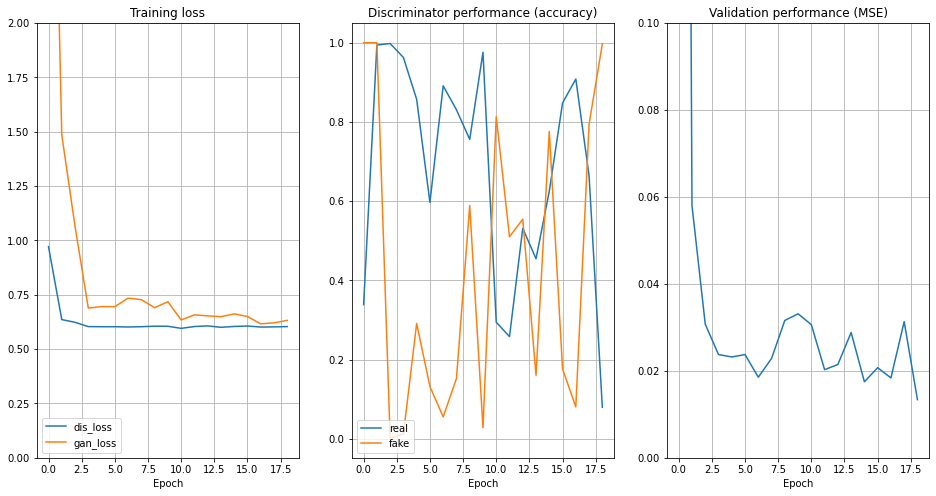

Done. Got val loss=0.013363958516668889 after epoch=18
HyperParam Sweep: Found it! Params: lr_gen=0.00015, lr_dis=0.0004, alpha=0.


In [13]:
lrs_dis = [0.00015, 0.00015, 0.000015, 0.00002, 0.002]
lrs_gan = [0.0004, 0.0005, 0.000005, 0.000005, 0.002]
alphas = [0]

generator = hyper_param_search(lrs_gan, lrs_dis, alphas)

Epoch 16, validation loss: 0.0123


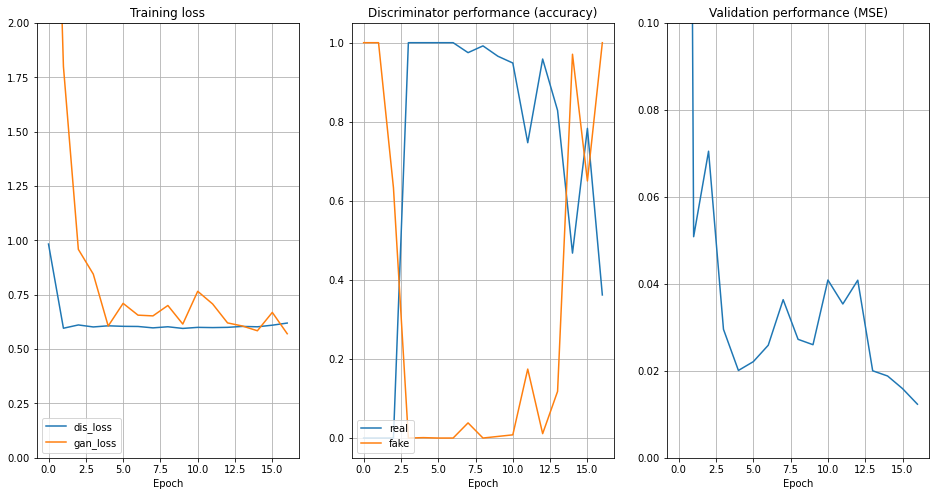

(0.012321043308944471, 16)

In [19]:
generator, dis, gan = build_model(learning_rate_dis=0.00015, learning_rate_GAN=0.0004, alpha=0)
train(generator, dis, gan)

# Discussion around the images

As we can see from the generated images below, they resemble the ground truth pretty well in its overall shape, but it is quite "noisy" and blurry. It does not really have the same highlighting as the ground truth. This can be problematic as it can be very difficult to then catch tumors or, more generally, trust the generated output. To get better looking images I believe that we can change the loss function on the generator to something that better handles small - but important - differences in the generated vs real images. As the mean squared error loss will have a good resemblance on average, it can loose smaller details in the image, such as correct tumor highlighting. A loss function that puts an equal importance on small areas as it does for larger areas can probably be benefitial (compare with the DICE loss that we used in image segmentation - DICE worked well to catch tumors regardless of its size. However DICE alone will not suffice as it relied on the pixel values only taking on two values representing the mask. We now have a continious range of values representing the brightness of the image.). It is possible that altering the loss function on the GAN model can also improve the image quality - If we can find a a good function that will lead to a very good discriminator and then train the generator to fool it we will of course also improve the images. Another way to increase the quality might be to increase the networks' complexity to learn even more features in the data.

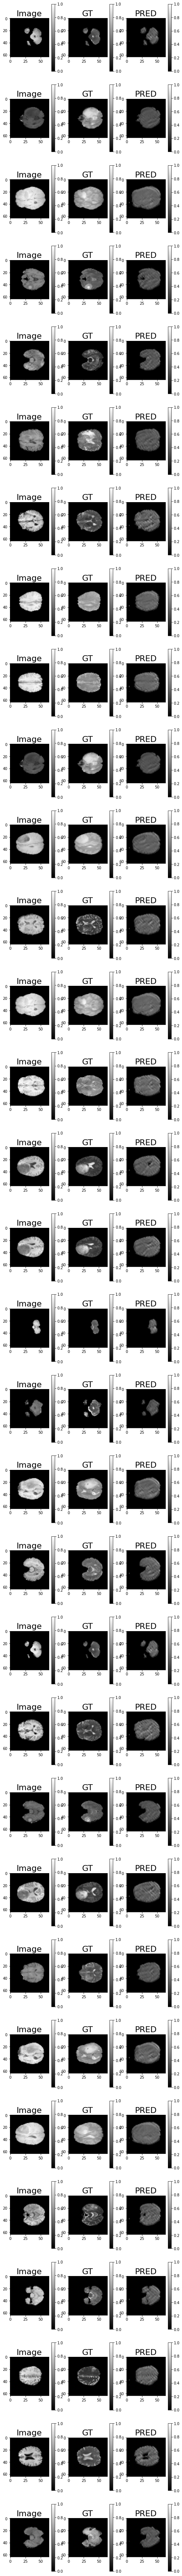

In [20]:
t1, t2 = gen_val[np.random.randint(0, len(gen_val))]
prediction = generator.predict(t1)
plt.figure(figsize=(8, 4 * batch_size))
for idx in range(batch_size):
    plt.subplot(batch_size, 3, idx * 3 + 1)
    plt.imshow(t1[idx, :, :], cmap='gray', vmin=0, vmax=1)
    plt.colorbar()
    plt.title('Image', fontsize=22)
    plt.subplot(batch_size, 3, idx * 3 + 2)
    plt.imshow(t2[idx, :, :], cmap='gray', vmin=0, vmax=1)
    plt.colorbar()
    plt.title('GT', fontsize=22)
    plt.subplot(batch_size, 3, idx * 3 + 3)
    plt.imshow(prediction[idx, :, :], cmap='gray', vmin=0, vmax=1)
    plt.colorbar()
    plt.title('PRED', fontsize=22)

# NOTE: How good do the images look like? What do you think is needed for better results?
# NOTE: Did you use alpha = 0? Describe the difficulty of balancing the two learning rates! Does that become easier by increasing alpha?

# Discussion

The performance on the testing set is actually better than that of the validation set. This at least says that we do not overfit on the validation set, but seem to generalize to new data well.

In [21]:
testing_loss = []
for idx, (t1, t2) in enumerate(gen_test):
    testing_loss.append(generator.test_on_batch(t1, t2))
print(np.mean(testing_loss))

# NOTE: Only evaluate the testing set, when you are not changing the code anymore.
# NOTE: How different is the performance on the validation and testing sets?
# NOTE: Do your results speak of overfitting? Underfitting?

0.00824537455675102
